# <font color="#ff9900"> **LSTM**</font>
---

Uma rede <font color="#66ffff"> **LSTM** (*Long short-term memory*)</font> é composta por unidades LSTM de uma RNN (*Recurrent Neural Network*). Tal unidade, denominada *cell* é formada tipicamente por uma *input gate*, uma *output gate* e uma *forget gate*. A *cell* é responsável por "lembrar" valores em intervalos de tempo arbitrários, daí o termo "*memory*" em LSTM. Cada uma das três *gates* pode ser considerada como um neurônio artificial "convencional", como em uma rede neural multicamada (ou *feedforward*): isto é, elas calculam uma ativação (usando uma função de ativação) de uma soma ponderada. Intuitivamente, elas podem ser vistas como reguladores do fluxo de valores que passa pelas conexões da LSTM; daí a denominação "*gate*". Existem conexões entre tais *gates* e a *cell*, assim as portas controlam os dados de entrada e saída da célula.

A expressão "*long short-term*" refere-se ao fato de que LSTM é um modelo para a **memória de curto prazo que pode durar por um longo período de tempo**. Um modelo LSTM é adequado para classificar, processar e prever séries temporais, considerando atrasos temporais de tamanho e duração desconhecidos entre eventos importantes. LSTMs foram desenvolvidos especificamente para lidar com os problemas *exploding gradient* e *vanishing gradient*, presentes no treinamento de RNNs tradicionais.

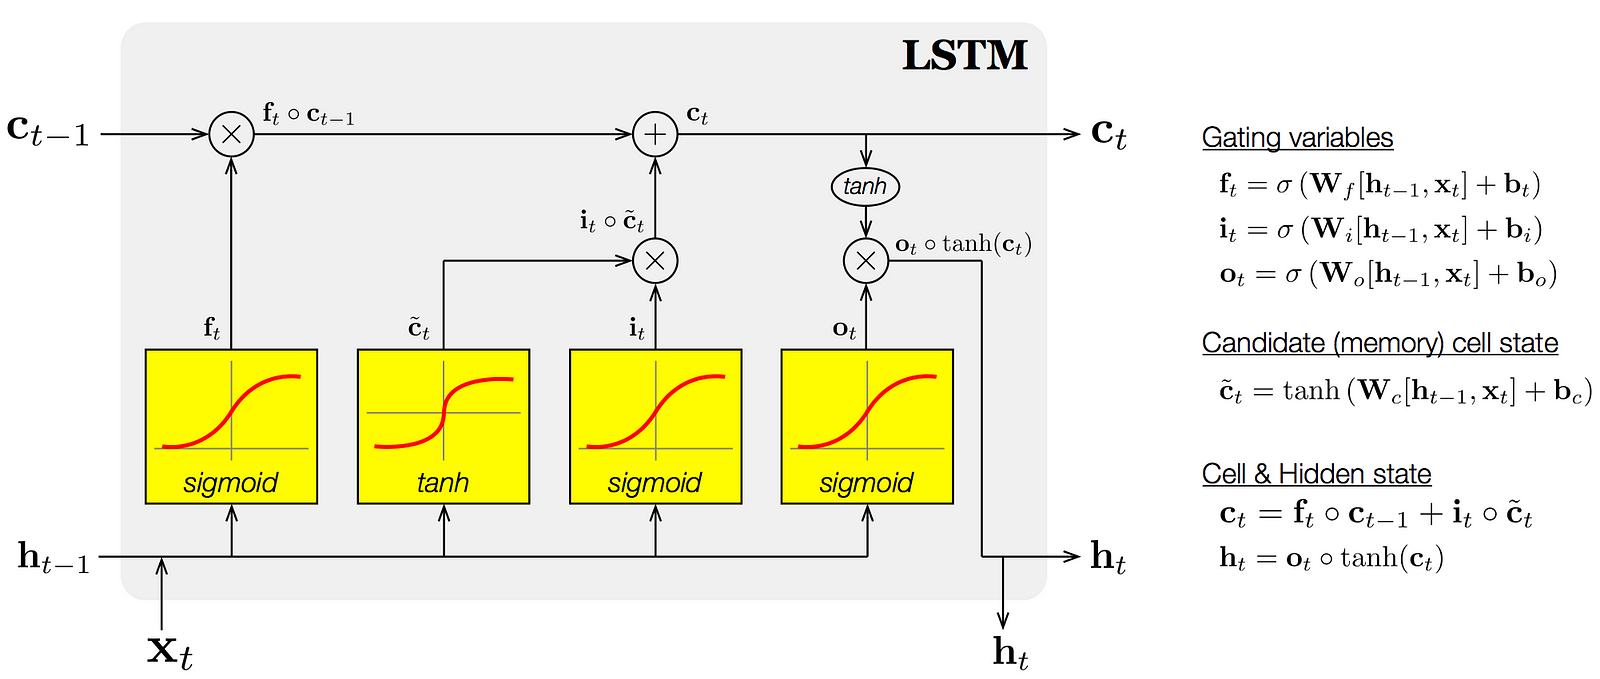

> Componentes de LSTMs

Na arquitetura LSTM convencional, uma célula LSTM (LSTM *cell*) contém os seguintes componentes:

- Forget Gate $f$ (uma NN com $sigmoid$)
- Candidate memory $\tilde{c}$ (uma NN com $tanh$)
- Input Gate $i$ (uma NN com $sigmoid$)
- Output Gate $o$ (uma NN com $sigmoid$)
- Hidden state $h$ (um vetor)
- Memory state $c$ (um vetor)
- Entradas para a LSTM *cell* em qualquer passo são $X_t$ (current input) , $h_{t-1}$ (previous hidden state ) e $c_{t-1}$ (previous memory state).
- Saídas da LSTM *cell* são $h_t$ (current hidden state) e $c_t$ (current memory state)

> *Gates*: Funcionamento

Primeiramente, a LSTM *cell* usa o *memory state* anterior $C_{t-1}$ e aplica uma multiplicação elemento a elemento com a *forget gate* ($f$) para decidir sobre o *memory state* atual $C_t$. Se o valor de *forget gate* é $0$ o *memory state* anterior é completamente esquecido. Já se o valor de $f$ for $1$ o *memory state* anterior é completamente passado para a célula. Lembrando que a $f$ *gate* retorna valores entre $0$ e $1$.

\begin{align}
  c_t = c_{t-1} \times f_t
\end{align}

Em seguida é calculado o novo *memory state*:

\begin{align}
   c_t = c_t + (i_t \times \tilde{c}_t)
\end{align}

E computada a saída

\begin{align}
   h_t = tanh(c_t)
\end{align}

# **Bibliotecas**</font>
---

Primeiramente vamos importar as bibliotecas a serem utilizadas.


In [ ]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# special style template for matplotlib, highly useful for visualizing time series data
plt.style.use("fivethirtyeight")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD

# **Dataset**</font>
---

Aqui vamos utilizar o *dataset*
<font color="#66ffff">**IBM Stocks**</font> disponível no `Kaggle` (https://www.kaggle.com/datasets/ranugadisansagamage/ibm-stocks). Esse *dataset* compila os preços de bolsa entre 01/01/1962 e 19/05/2022 de ações da **IBM** (*International Business Machines Corporation*).

Por conveniência, disponibilizei o *dataset* no formato `CSV` em (https://tsi.td.utfpr.edu.br/~faspanhol/dataset/kaggle_IBM_stocks.csv). Assim vamos primeiramente baixar o arquivo `CSV`.

In [ ]:
!wget https://tsi.td.utfpr.edu.br/~faspanhol/dataset/kaggle_IBM_stocks.csv

--2024-07-16 22:29:08--  https://tsi.td.utfpr.edu.br/~faspanhol/dataset/kaggle_IBM_stocks.csv
Resolving tsi.td.utfpr.edu.br (tsi.td.utfpr.edu.br)... 200.134.31.236, 2801:82:c00d:40::236
Connecting to tsi.td.utfpr.edu.br (tsi.td.utfpr.edu.br)|200.134.31.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1055464 (1.0M) [text/csv]
Saving to: ‘kaggle_IBM_stocks.csv’

kaggle_IBM_stocks.c 100%[===================>]   1.01M   250KB/s    in 4.3s    

2024-07-16 22:29:15 (238 KB/s) - ‘kaggle_IBM_stocks.csv’ saved [1055464/1055464]



In [ ]:
!ls -lh kaggle_IBM_stocks.csv

-rw-r--r-- 1 root root 1.1M Jul 13 13:44 kaggle_IBM_stocks.csv


*Super!* Temos um *dataset* com séries temporais. 😉

# **Informações Básicas Sobre o Dataset**</font>
---

Vamos carregar o arquivo `kaggle_IBM_stocks.csv` do diretório atual e exibir algumas informações básicas. Vamos utilizar a `Pandas` que é uma biblioteca de *open-source* para a manipulação e análise de dados em Python. Ela oferece estruturas de dados de alto desempenho e ferramentas para trabalhar com dados estruturados (tabulares, séries temporais, etc.).

In [ ]:
df = pd.read_csv("kaggle_IBM_stocks.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15202 entries, 0 to 15201
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       15202 non-null  object 
 1   Open       15202 non-null  float64
 2   High       15202 non-null  float64
 3   Low        15202 non-null  float64
 4   Close      15202 non-null  float64
 5   Adj Close  15202 non-null  float64
 6   Volume     15202 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 831.5+ KB


As colunas representam os dados de negociação diários de ações da empresa no mercado de ação, sendo:

- `Open` (Abertura): Este é o preço pelo qual uma ação começa a ser negociada quando o mercado abre para o dia. Representa o primeiro preço de transação da ação para essa sessão de negociação.

- `High` (Alta): Este é o preço mais alto pelo qual uma ação é negociada durante o dia de negociação. Indica o preço máximo que os compradores estavam dispostos a pagar pela ação durante essa sessão.

- `Low`(Baixa): Este é o preço mais baixo pelo qual uma ação é negociada durante o dia de negociação. Reflete o preço mínimo que os vendedores estavam dispostos a aceitar pela ação durante essa sessão.

- `Close` (Fechamento): Este é o preço pelo qual uma ação é negociada pela última vez quando o mercado fecha para o dia. É considerado o preço mais importante do dia porque reflete o consenso final do valor da ação até a reabertura do mercado.

- `Adj Close` (Fechamento Ajustado): Este é o preço de fechamento ajustado para quaisquer ações corporativas, como dividendos, desdobramentos de ações ou novas emissões de ações que ocorreram antes da abertura do próximo dia. Ele fornece uma reflexão mais precisa do valor da ação ao longo do tempo, levando em conta esses ajustes.

- `Volume` (Volume): Este é o número total de ações da empresa que foram negociadas durante o dia de negociação. Indica o nível de atividade ou liquidez da ação; um volume maior sugere mais interesse e atividade na ação.

O método `read_csv` cria um objeto `DataFrame` em memória. Um `DataFrame` é um tabela de dados bidimensional com linhas (*rows*) e colunas (*columns*) índices, similar a uma planilha. As colunas são feitas de objetos `Series`, um *array* de dados unidimensional e ordenado com um índice. Todos os dados presentes em um `Series` são do mesmo tipo.

No nosso `DataFrame` temos 15202 entradas (*rows*) obtidas do arquivo, com 7 colunas.

Agora vamos exibir as três primeiras linhas.

In [ ]:
df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1962-01-02,7.374124,7.374124,7.291268,7.291268,1.673325,407940
1,1962-01-03,7.291268,7.355003,7.291268,7.355003,1.687950,305955
2,1962-01-04,7.355003,7.355003,7.278521,7.281708,1.671130,274575


E três linhas randomicamente selecionadas.

In [ ]:
df.sample(3)  # random 3 rows

,Date,Open,High,Low,Close,Adj Close,Volume
10840,2005-01-25,87.934990,88.518166,87.906311,88.135757,53.869587,5303952
13235,2014-07-31,184.359467,185.745697,183.116638,183.240921,130.997589,4401045
15147,2022-03-04,124.400002,127.349998,124.209999,126.620003,125.102440,4402400


# **Preparação do Dataset**</font>
---

Efetivamente vamos utilizar um *subset* do *dataset* original, isto é, os preços entre os anos de 2000 e 2022. Assim, vamos carregar novamente o arquivo `kaggle_IBM_stocks.csv` do diretório atual com alguns ajustes. Primeiramente tornar a coluna `Date` índice do *DataFrame*, visto que temos dados de série temporal. Depois instruir que a coluna `Date`seja tratada como objeto *date-time* e não *string*, facilitando as operações seguintes de filtragem.

Agora iremos dividir o *dataset* em `training_set` (de 2000 a 2018) e `test_set` (2019 a 2022).

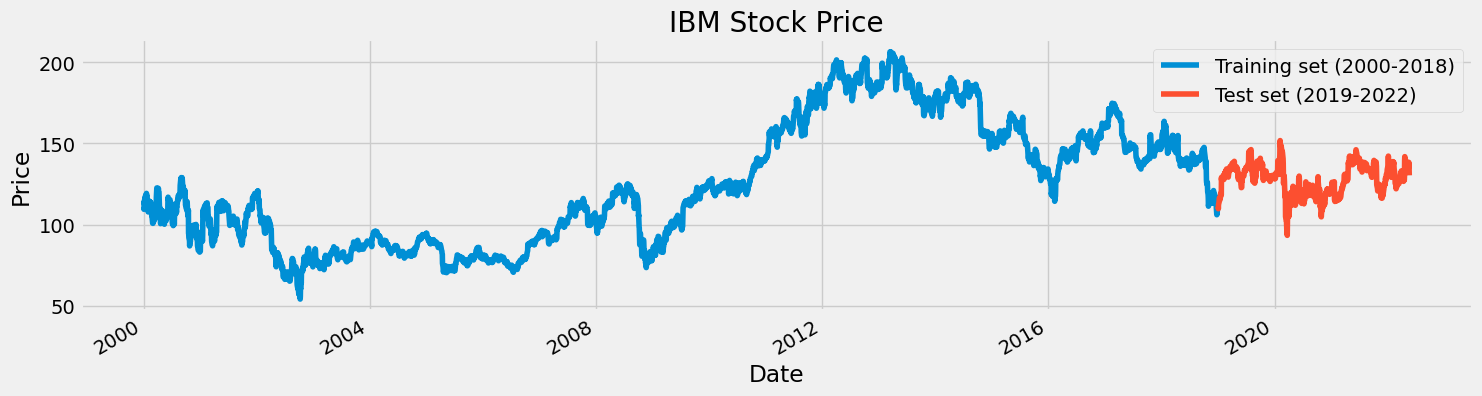

In [ ]:
df = pd.read_csv("kaggle_IBM_stocks.csv", index_col="Date", parse_dates=True)

# Subsets
training_set = df["2000":"2018"].iloc[:, 1:2].values
test_set = df["2019":].iloc[:, 1:2].values

# Time series visualization
df["High"]["2000":"2018"].plot(figsize=(16, 4), legend=True)
df["High"]["2019":].plot(figsize=(16, 4), legend=True)

plt.title("IBM Stock Price")
plt.legend(["Training set (2000-2018)", "Test set (2019-2022)"])

plt.xlabel("Date")
plt.ylabel("Price")

plt.show()

In [ ]:
print(f"Training set: {training_set.shape}")
print(f"First 3 rows:\n{training_set[0:3]}\n")

print(f"Test set: {test_set.shape}")
print(f"First 3 rows:\n{test_set[0:3]}")

Training set: (4779, 1)
First 3 rows:
[[110.898659]
 [109.46463 ]
 [114.483749]]

Test set: (854, 1)
First 3 rows:
[[110.879539]
 [109.827919]
 [112.323135]]


> **Transformação de Escala**

Agora vamos transformar os dados de treinamento, deixando-os na mesma escala, na faixa $0 - 1$.

In [ ]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
print(f"Training set scaled: {training_set_scaled.shape}")
print(f"First 3 rows:\n{training_set_scaled[0:3]}\n")

Training set scaled: (4779, 1)
First 3 rows:
[[0.37248743]
 [0.36306535]
 [0.39604273]]



Ajustada a escala vamos criar os dados para o modelo LSTM, separando `training_set_scaled` nas variáveis `X_train` (*input*) e `y_train` (*output*):  
- `X_train` é um *array* 3D $(4719, 60, 1)$, sendo 4719 a quantidade de exemplos de treinamento, 60 quantidade de passos de time (*time steps*) e 1 a quantidade de *features* (no nosso caso apenas o atributo `High`).
- `y_train` é um *array* 1D de preços das ações que correspondem ao último *time step* em cada sequência de entrada.

In [ ]:
# LSTMs leverage long-term memory, so we create a data structure with 60 timesteps and 1 output.
# We have sliding windows of 60 time steps as input features.
# For each training set element, we use the previous 60 elements to predict the next value.

X_train = []
y_train = []

for i in range(60, 4779):
    #  Add previous 60 data points up to but not including the current point
    X_train.append(training_set_scaled[i - 60 : i, 0])

    # Add current point
    y_train.append(training_set_scaled[i, 0])

# Convert to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape to [batch_size, timesteps, features], required by the LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


Esses são os *datasets* prontos para o treinamento do nosso modelo LSTM.

In [ ]:
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")


X_train: (4719, 60, 1)
y_train: (4719,)


Vamos criar também uma função auxiliar `plot_predictions` para exibir as curvas dos preços reais e dos preços preditos por nosso modelo.

In [ ]:
def plot_predictions(test, predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

# **Definição do Modelo e Treinamento**</font>
---

Vamos criar uma arquitetura com quatro camadas LSTM, cada uma com 20 unidades (*neurons*). Como vimos, cada unidade LSTM contém uma célula de memória que captura as dependências na sequência de entrada. O parâmetro `return_sequences` indica que a camada LSTM deve retornar a sequência completa de saídas para cada sequência de entrada, não apenas a saída do último intervalo de tempo. Isso é útil ao se empilhar múltiplas camadas LSTM ou quando se precisa de uma sequência de saída para tarefas como previsão de sequência.   

A camada *Dropout*, com $0.2$, indica um percentual de $20\%$. Lembrando que *dropout* é uma técnica de regularização usada para prevenir *overfitting*, aleatoriamente descartando uma fração das entradas durante o treinamento.


In [ ]:
# The LSTM architecture
regressor = Sequential()

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=20, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=20, return_sequences=True))
regressor.add(Dropout(0.2))

# Third LSTM layer
regressor.add(LSTM(units=20, return_sequences=True))
regressor.add(Dropout(0.2))

# Fourth LSTM layer
regressor.add(LSTM(units=20))
regressor.add(Dropout(0.2))

# The output layer
regressor.add(Dense(units=1))

print(regressor.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 60, 20)            1760      
                                                                 
 dropout_16 (Dropout)        (None, 60, 20)            0         
                                                                 
 lstm_17 (LSTM)              (None, 60, 20)            3280      
                                                                 
 dropout_17 (Dropout)        (None, 60, 20)            0         
                                                                 
 lstm_18 (LSTM)              (None, 60, 20)            3280      
                                                                 
 dropout_18 (Dropout)        (None, 60, 20)            0         
                                                                 
 lstm_19 (LSTM)              (None, 20)               

Definida a arquitetura vamos usar o método `compile` para para configurar o processo de aprendizado do modelo. O parâmetro `loss` é setado para `mean_squared_error`, indicando que a função *loss* no treinamento será a *Mean Squared Error* (MSE). Essa função é comumente usado em tarefas de regressão para medir a diferença quadrática média entre os valores previstos e os valores reais. Já o parâmetro `optmizer` especifica que o otimizador a ser utilizado para atualizar os pesos da rede será o Adam (*Adaptive Moment Estimation*), que ajusta dinamicamente o *learning rate*.

In [ ]:
# Compiling the RNN
regressor.compile(loss='mean_squared_error', optimizer='adam')  # optimizer='rmsprop'

# Fitting to the training set and storing the training history
history = regressor.fit(X_train, y_train, epochs=20, batch_size=64)

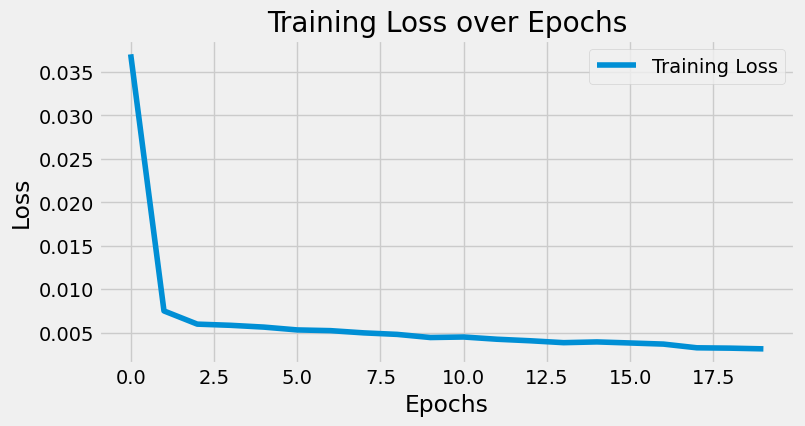

In [ ]:
# Plotting the training loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Teste**</font>
---

> Criação do *test dataset*

In [ ]:
# Prepare the test set similarly to the training set.
# The first 60 entries of the test set need the 60 previous values for proper processing.
# To achieve this, we must use the entire 'High' attribute data for creating the test set.
dataset_total = pd.concat((df["High"]["2000":"2018"],df["High"]["2019":]),axis=0)

inputs = dataset_total[len(dataset_total) - len(test_set) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs  = sc.transform(inputs)

In [ ]:
print(f"Inputs: {inputs.shape}")

Inputs: (914, 1)


> Predição

In [ ]:
# Preparing X_test
X_test = []
for i in range(60, 914):
    X_test.append(inputs[i-60:i,0])

# Convert to numpy
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

# Make predictions
predicted_stock_price = regressor.predict(X_test)

# Convert the normalized predicted values back to the original scale
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

27/27 [==============================] - 2s 23ms/step


In [ ]:
print(test_set.shape)
print(predicted_stock_price.shape)

(854, 1)
(854, 1)


# **Avaliação**</font>
---
Primeiramente vamos fazer uma avaliação visual da regressão, comparando as duas curvas.

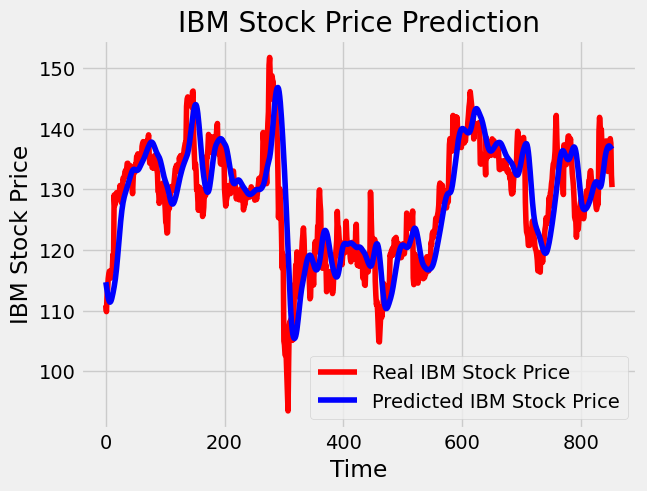

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set, predicted_stock_price)

> Avaliação numérica

Na avaliação de modelos de regressão é muito comum se usar a métrica *Root Mean Squared Error* ($RMSE$). Um valor pequeno de RMSE indica que as predições do modelo estão próximas aos valores reais.

$RMSE$ é calculada da seguinte forma:
\begin{align}
   RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^n(y_i - \hat{y}_i)^2}
\end{align}

sendo
- $y_i$ o valor real;
- $\hat{y}_i$ o valor predito e
- $n$ a quantidade de observações.

In [ ]:
# Evaluating the model using RMSE

rmse = math.sqrt(mean_squared_error(test_set, predicted_stock_price))

print(f"The root mean squared error is {rmse}.")

The root mean squared error is 6.022869826414595.




*Les carottes sont cuites!* 🥕🥕🥕

---
<font color="#ffb31a">Fabio Alexandre **SPANHOL**</font> <faspanhol@gmail.com>

<font color="#cccccc">*Updated: July 17th 2024*</font>